# Loss Component Visualization

This notebook visualizes the training progression of the full model (WMSE + SSIM + Edge + Intensity KL) from the checkpoint directory.

**Checkpoint Directory**: `hisnegs/src/renderer/checkpoints/train_swme_ssim_edge_inte_checkpoint`

## Loss Components:
- **WMSE**: Weighted Mean Squared Error (foreground-weighted reconstruction)
- **SSIM**: 1 - Structural Similarity Index (perceptual structure)
- **Edge**: Sobel gradient matching (fine detail sharpness)
- **Sparsity/IntKL**: KL divergence on intensity histograms (global brightness distribution)
- **Scale Reg**: Scale regularization penalty
- **Total Loss**: Sum of all weighted components

## 1. Load Required Libraries

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Load Training History

In [2]:
# Path to training history
history_path = Path('/workspace/hisnegs/src/renderer/checkpoints/train_swme_ssim_edge_inte_checkpoint/training_history.json')

# Load the JSON data
with open(history_path, 'r') as f:
    history = json.load(f)

# Convert to numpy arrays for easier manipulation
epochs = np.arange(1, len(history) + 1)
total_loss = np.array([h['loss'] for h in history])
mse_loss = np.array([h['mse'] for h in history])
ssim_loss = np.array([1.0 - h['ssim'] for h in history])  # Convert SSIM metric to loss
edge_loss = np.array([h['edge'] for h in history])
sparsity_loss = np.array([h.get('sparsity', 0.0) for h in history])  # IntKL term
scale_reg = np.array([h['scale_reg'] for h in history])
psnr = np.array([h['psnr'] for h in history])
mae = np.array([h['mae'] for h in history])
n_gaussians = np.array([h['n_visible'] for h in history])

print(f"Loaded {len(history)} epochs of training history")
print(f"Epochs: {epochs[0]} → {epochs[-1]}")
print(f"Final PSNR: {psnr[-1]:.2f} dB")
print(f"Final Total Loss: {total_loss[-1]:.6f}")

Loaded 2000 epochs of training history
Epochs: 1 → 2000
Final PSNR: 38.39 dB
Final Total Loss: 0.001843


## 3. Overview: All Loss Components Together

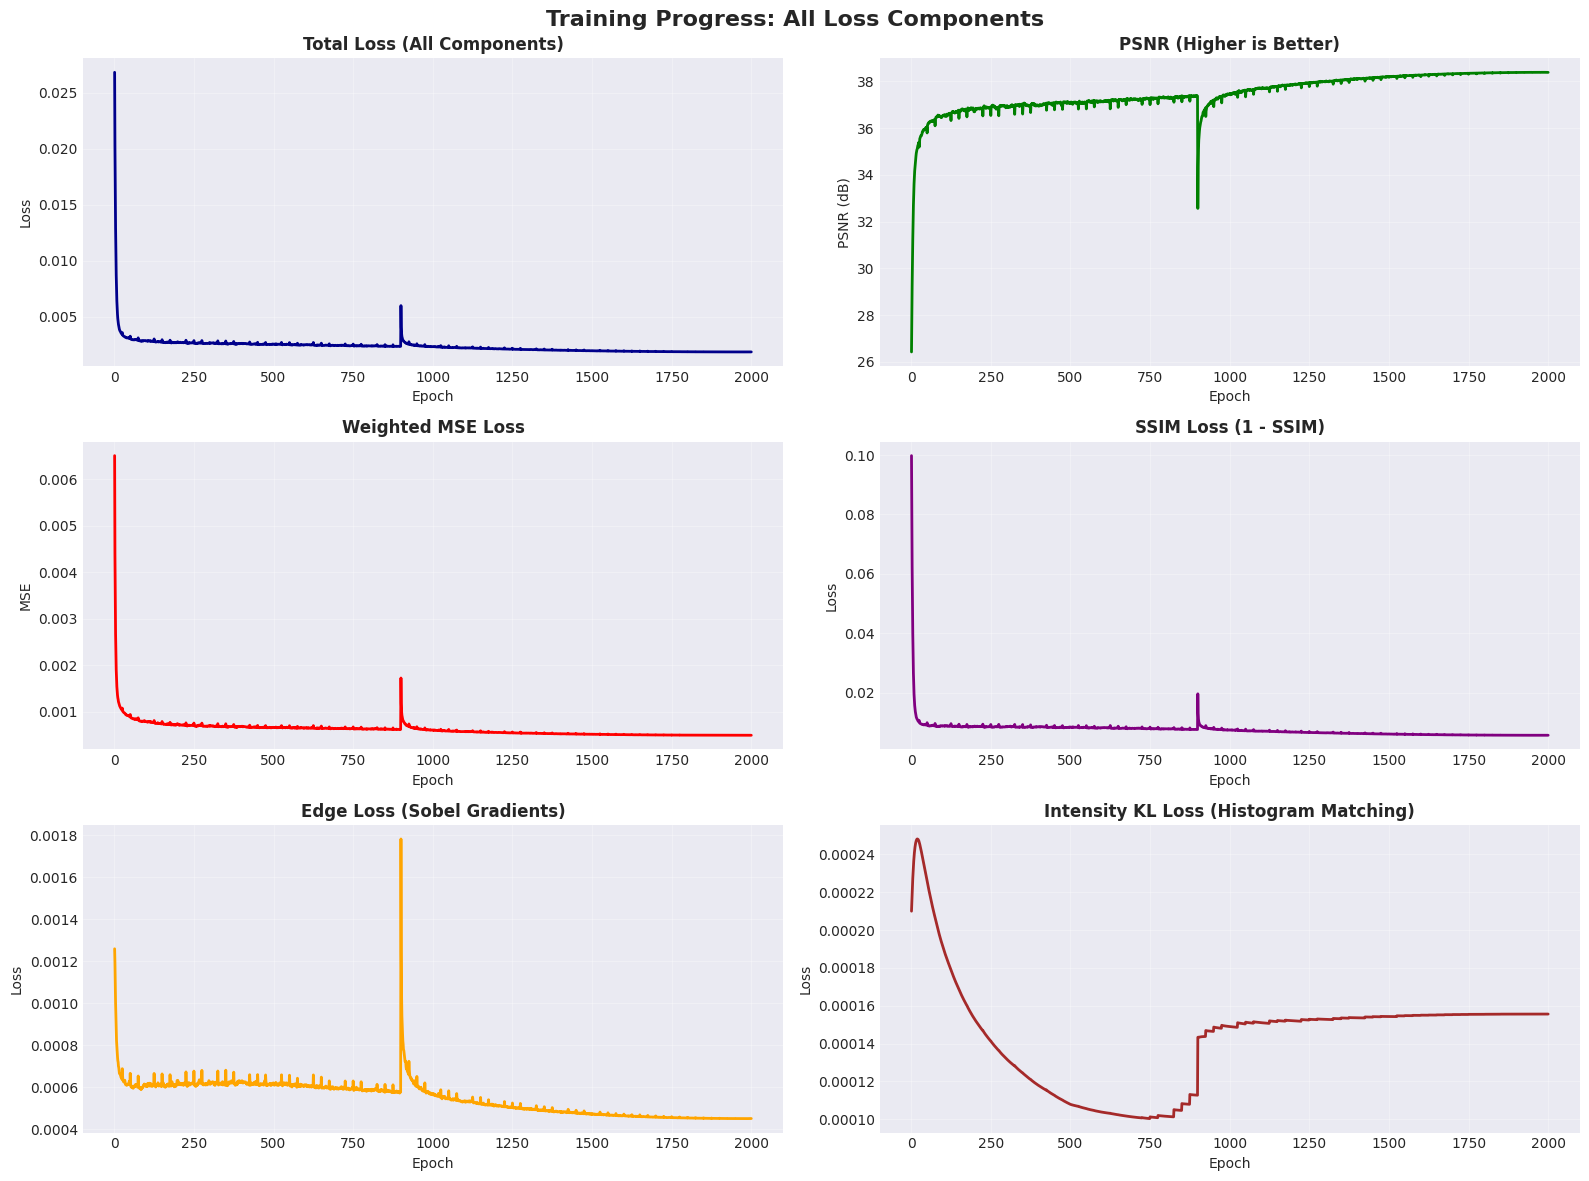

In [3]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Training Progress: All Loss Components', fontsize=16, fontweight='bold')

# Total Loss
axes[0, 0].plot(epochs, total_loss, linewidth=2, color='darkblue')
axes[0, 0].set_title('Total Loss (All Components)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# PSNR (quality metric)
axes[0, 1].plot(epochs, psnr, linewidth=2, color='green')
axes[0, 1].set_title('PSNR (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].grid(True, alpha=0.3)

# WMSE
axes[1, 0].plot(epochs, mse_loss, linewidth=2, color='red')
axes[1, 0].set_title('Weighted MSE Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].grid(True, alpha=0.3)

# SSIM Loss (1 - SSIM)
axes[1, 1].plot(epochs, ssim_loss, linewidth=2, color='purple')
axes[1, 1].set_title('SSIM Loss (1 - SSIM)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].grid(True, alpha=0.3)

# Edge Loss
axes[2, 0].plot(epochs, edge_loss, linewidth=2, color='orange')
axes[2, 0].set_title('Edge Loss (Sobel Gradients)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].grid(True, alpha=0.3)

# Intensity KL Loss
axes[2, 1].plot(epochs, sparsity_loss, linewidth=2, color='brown')
axes[2, 1].set_title('Intensity KL Loss (Histogram Matching)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('Loss')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Individual Loss Component Analysis

### 4.1 Total Loss Evolution

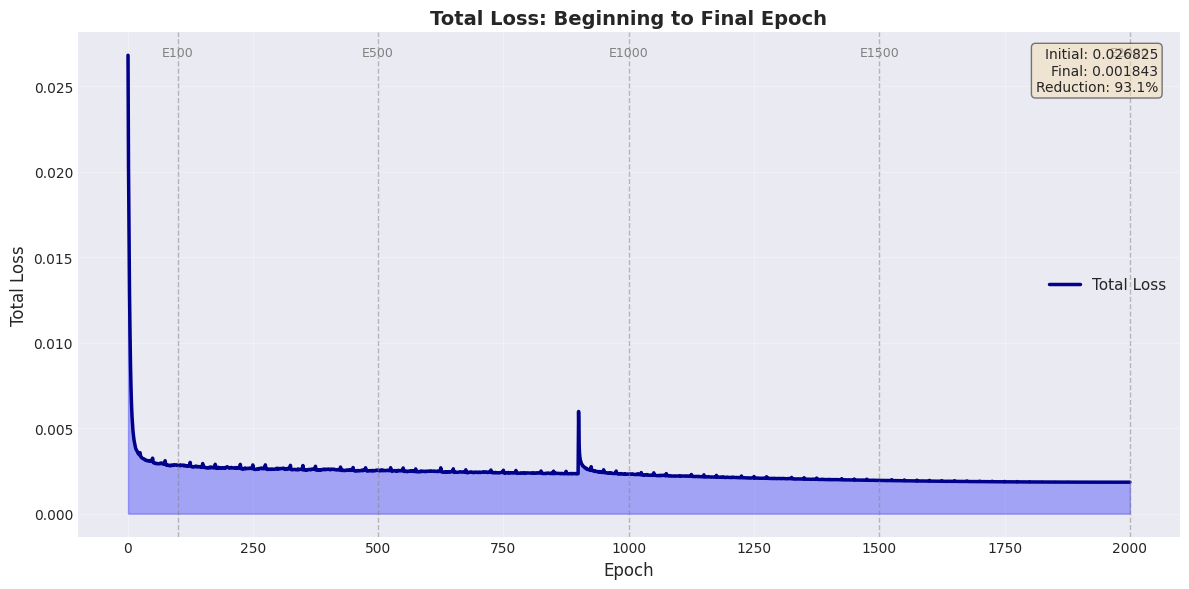

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, total_loss, linewidth=2.5, color='darkblue', label='Total Loss')
ax.fill_between(epochs, total_loss, alpha=0.3, color='blue')

# Mark key milestones
milestones = [100, 500, 1000, 1500, 2000]
for ms in milestones:
    if ms <= len(epochs):
        ax.axvline(ms, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        ax.text(ms, ax.get_ylim()[1] * 0.95, f'E{ms}', 
               ha='center', fontsize=9, color='gray')

ax.set_title('Total Loss: Beginning to Final Epoch', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Total Loss', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics box
stats_text = f'Initial: {total_loss[0]:.6f}\nFinal: {total_loss[-1]:.6f}\nReduction: {(1-total_loss[-1]/total_loss[0])*100:.1f}%'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 4.2 Weighted MSE (Reconstruction Loss)

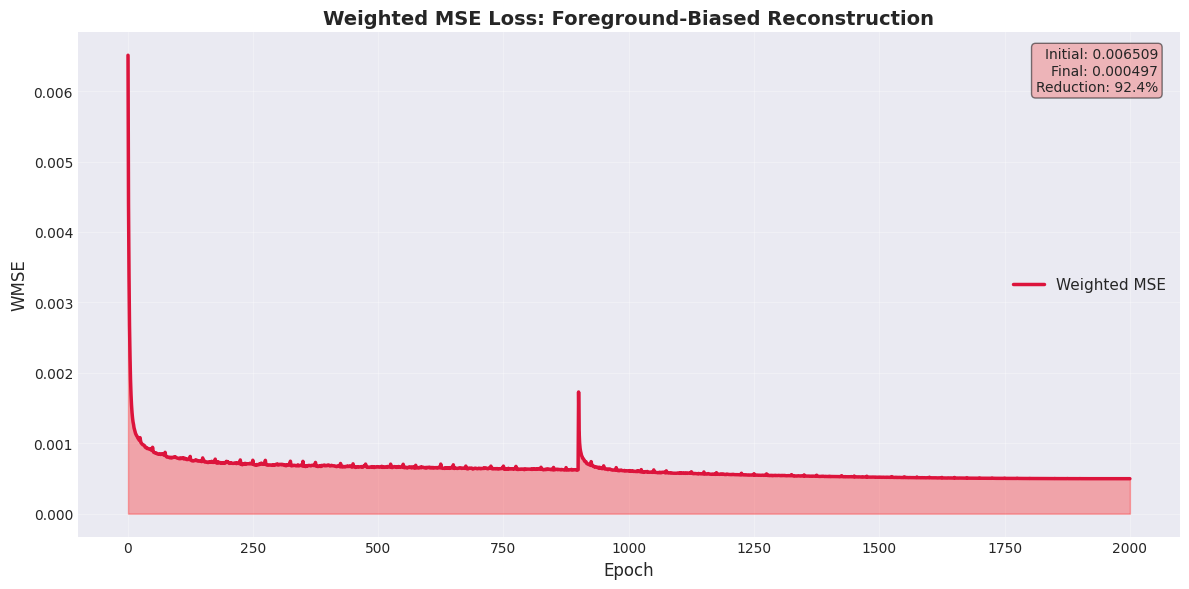


WMSE Analysis:
  Initial value: 0.006509
  Final value: 0.000497
  Reduction: 92.37%
  Min value: 0.000496 (epoch 1998)


In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, mse_loss, linewidth=2.5, color='crimson', label='Weighted MSE')
ax.fill_between(epochs, mse_loss, alpha=0.3, color='red')

ax.set_title('Weighted MSE Loss: Foreground-Biased Reconstruction', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('WMSE', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Initial: {mse_loss[0]:.6f}\nFinal: {mse_loss[-1]:.6f}\nReduction: {(1-mse_loss[-1]/mse_loss[0])*100:.1f}%'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nWMSE Analysis:")
print(f"  Initial value: {mse_loss[0]:.6f}")
print(f"  Final value: {mse_loss[-1]:.6f}")
print(f"  Reduction: {(1-mse_loss[-1]/mse_loss[0])*100:.2f}%")
print(f"  Min value: {mse_loss.min():.6f} (epoch {np.argmin(mse_loss)+1})")

### 4.3 SSIM Loss (Structural Similarity)

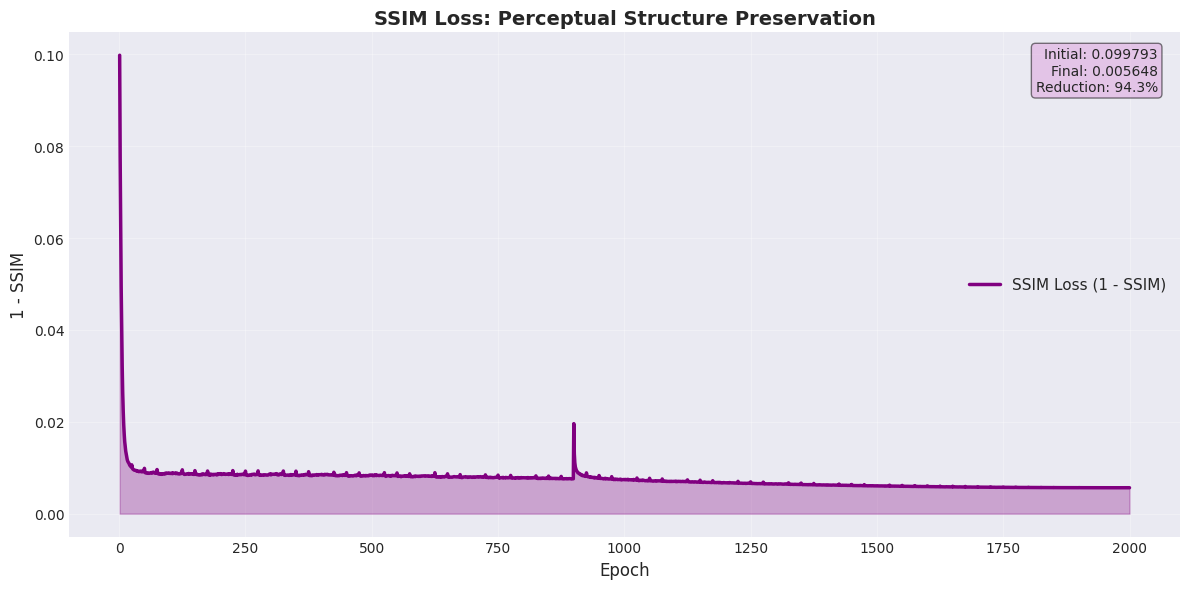


SSIM Analysis:
  Initial SSIM: 0.900207
  Final SSIM: 0.994352
  Loss reduction: 94.34%
  Best SSIM: 0.994359 (epoch 1998)


In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, ssim_loss, linewidth=2.5, color='purple', label='SSIM Loss (1 - SSIM)')
ax.fill_between(epochs, ssim_loss, alpha=0.3, color='purple')

ax.set_title('SSIM Loss: Perceptual Structure Preservation', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('1 - SSIM', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Initial: {ssim_loss[0]:.6f}\nFinal: {ssim_loss[-1]:.6f}\nReduction: {(1-ssim_loss[-1]/ssim_loss[0])*100:.1f}%'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='plum', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nSSIM Analysis:")
print(f"  Initial SSIM: {1-ssim_loss[0]:.6f}")
print(f"  Final SSIM: {1-ssim_loss[-1]:.6f}")
print(f"  Loss reduction: {(1-ssim_loss[-1]/ssim_loss[0])*100:.2f}%")
print(f"  Best SSIM: {1-ssim_loss.min():.6f} (epoch {np.argmin(ssim_loss)+1})")

### 4.4 Edge Loss (Gradient Matching)

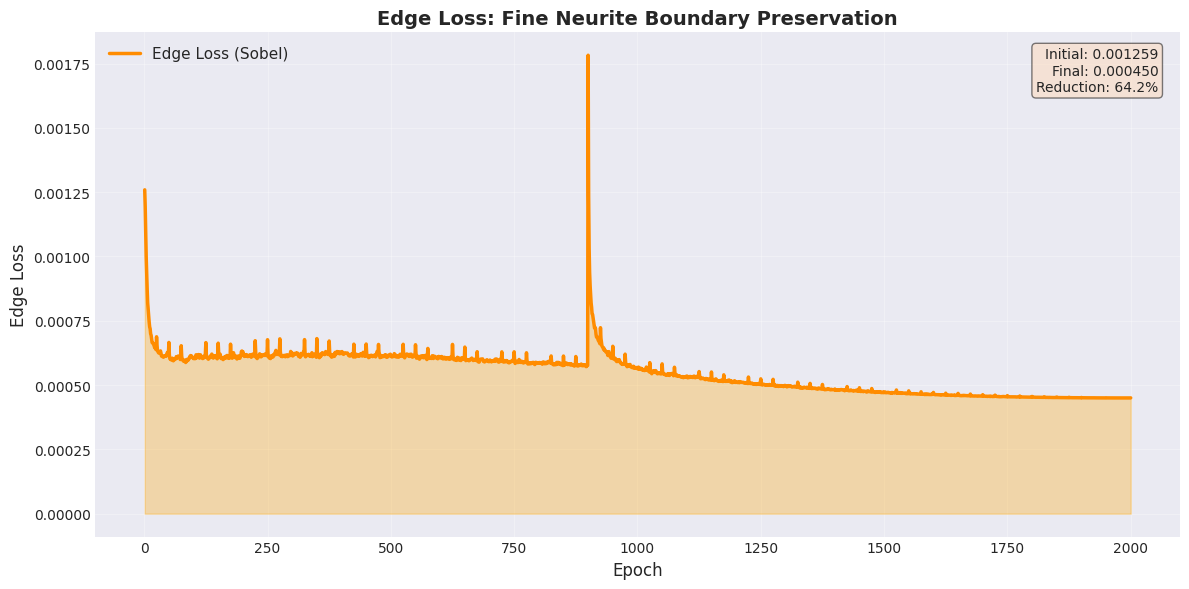


Edge Loss Analysis:
  Initial value: 0.001259
  Final value: 0.000450
  Reduction: 64.24%
  Min value: 0.000450 (epoch 1998)


In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, edge_loss, linewidth=2.5, color='darkorange', label='Edge Loss (Sobel)')
ax.fill_between(epochs, edge_loss, alpha=0.3, color='orange')

ax.set_title('Edge Loss: Fine Neurite Boundary Preservation', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Edge Loss', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Initial: {edge_loss[0]:.6f}\nFinal: {edge_loss[-1]:.6f}\nReduction: {(1-edge_loss[-1]/edge_loss[0])*100:.1f}%'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='peachpuff', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nEdge Loss Analysis:")
print(f"  Initial value: {edge_loss[0]:.6f}")
print(f"  Final value: {edge_loss[-1]:.6f}")
print(f"  Reduction: {(1-edge_loss[-1]/edge_loss[0])*100:.2f}%")
print(f"  Min value: {edge_loss.min():.6f} (epoch {np.argmin(edge_loss)+1})")

### 4.5 Intensity KL Loss (Histogram Matching)

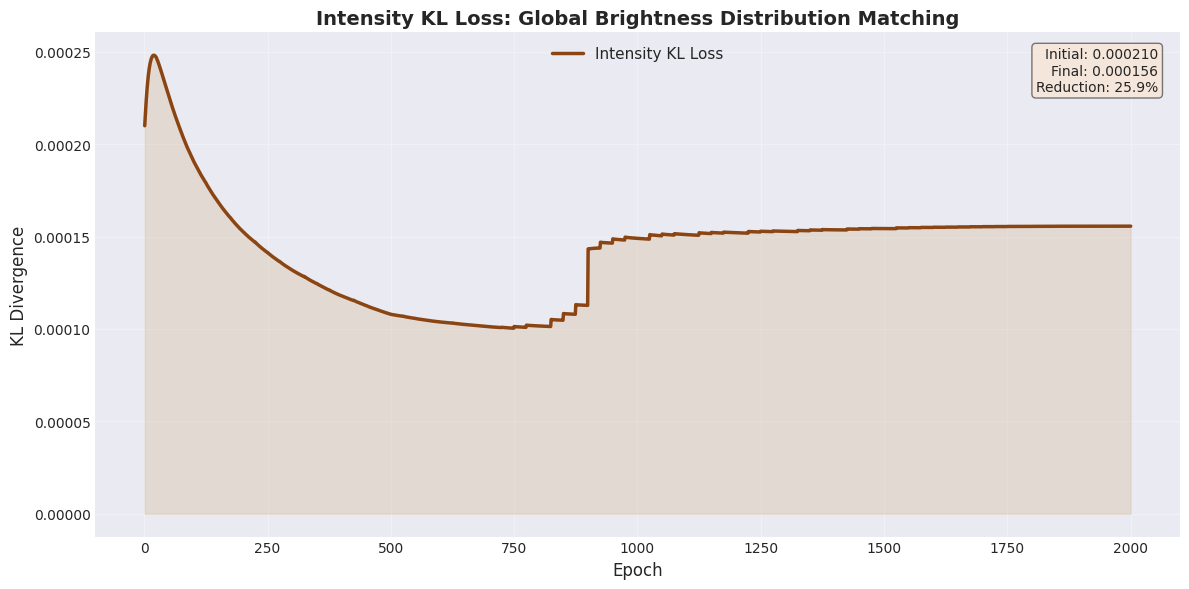


Intensity KL Loss Analysis:
  Initial value: 0.000210
  Final value: 0.000156
  Reduction: 25.89%
  Min value: 0.000100 (epoch 749)


In [8]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, sparsity_loss, linewidth=2.5, color='saddlebrown', label='Intensity KL Loss')
ax.fill_between(epochs, sparsity_loss, alpha=0.3, color='tan')

ax.set_title('Intensity KL Loss: Global Brightness Distribution Matching', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('KL Divergence', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Initial: {sparsity_loss[0]:.6f}\nFinal: {sparsity_loss[-1]:.6f}'
if sparsity_loss[0] > 0:
    stats_text += f'\nReduction: {(1-sparsity_loss[-1]/sparsity_loss[0])*100:.1f}%'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='bisque', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nIntensity KL Loss Analysis:")
print(f"  Initial value: {sparsity_loss[0]:.6f}")
print(f"  Final value: {sparsity_loss[-1]:.6f}")
if sparsity_loss[0] > 0:
    print(f"  Reduction: {(1-sparsity_loss[-1]/sparsity_loss[0])*100:.2f}%")
print(f"  Min value: {sparsity_loss.min():.6f} (epoch {np.argmin(sparsity_loss)+1})")

### 4.6 Scale Regularization

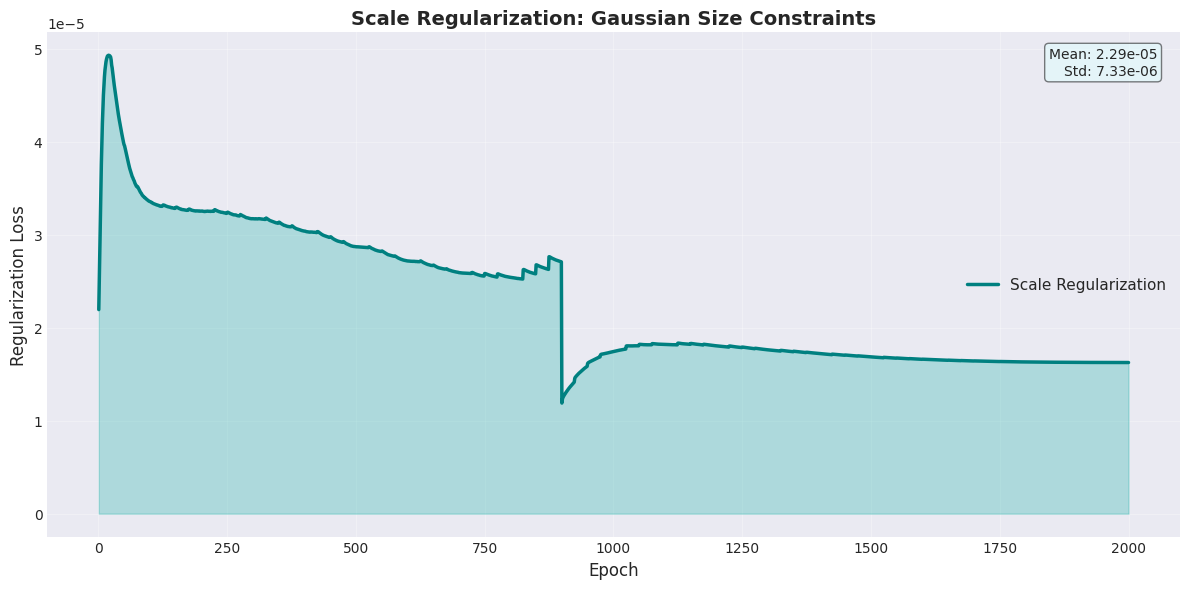


Scale Regularization Analysis:
  Mean value: 2.29e-05
  Std dev: 7.33e-06
  Range: [1.19e-05, 4.93e-05]


In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(epochs, scale_reg, linewidth=2.5, color='teal', label='Scale Regularization')
ax.fill_between(epochs, scale_reg, alpha=0.3, color='lightseagreen')

ax.set_title('Scale Regularization: Gaussian Size Constraints', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Regularization Loss', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Add statistics
stats_text = f'Mean: {scale_reg.mean():.2e}\nStd: {scale_reg.std():.2e}'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
       fontsize=10, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nScale Regularization Analysis:")
print(f"  Mean value: {scale_reg.mean():.2e}")
print(f"  Std dev: {scale_reg.std():.2e}")
print(f"  Range: [{scale_reg.min():.2e}, {scale_reg.max():.2e}]")

## 5. Comparative Analysis: Loss Component Contributions

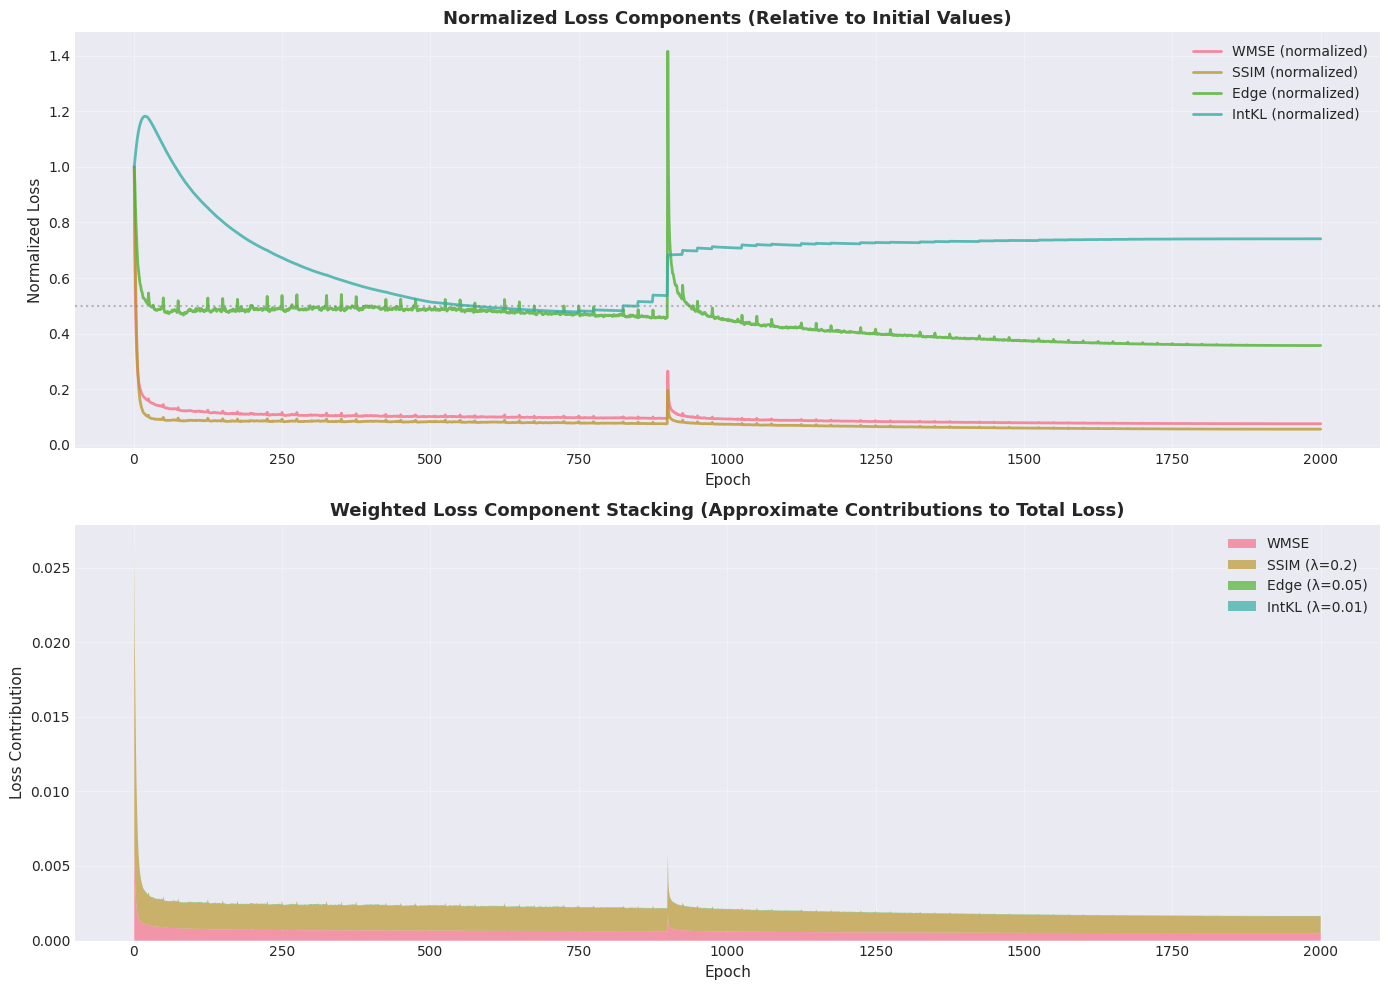

In [10]:
# Normalize each component to see relative contributions
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: All components on same scale (normalized)
ax = axes[0]
ax.plot(epochs, mse_loss / mse_loss[0], linewidth=2, label='WMSE (normalized)', alpha=0.8)
ax.plot(epochs, ssim_loss / ssim_loss[0], linewidth=2, label='SSIM (normalized)', alpha=0.8)
ax.plot(epochs, edge_loss / edge_loss[0], linewidth=2, label='Edge (normalized)', alpha=0.8)
if sparsity_loss[0] > 0:
    ax.plot(epochs, sparsity_loss / sparsity_loss[0], linewidth=2, label='IntKL (normalized)', alpha=0.8)

ax.set_title('Normalized Loss Components (Relative to Initial Values)', fontsize=13, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Normalized Loss', fontsize=11)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5, label='50% reduction')

# Plot 2: Stacked area chart showing absolute contributions
ax = axes[1]
ax.stackplot(epochs, mse_loss, ssim_loss * 0.2, edge_loss * 0.05, sparsity_loss * 0.01,
            labels=['WMSE', 'SSIM (λ=0.2)', 'Edge (λ=0.05)', 'IntKL (λ=0.01)'],
            alpha=0.7)

ax.set_title('Weighted Loss Component Stacking (Approximate Contributions to Total Loss)', 
            fontsize=13, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss Contribution', fontsize=11)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Quality Metrics Evolution

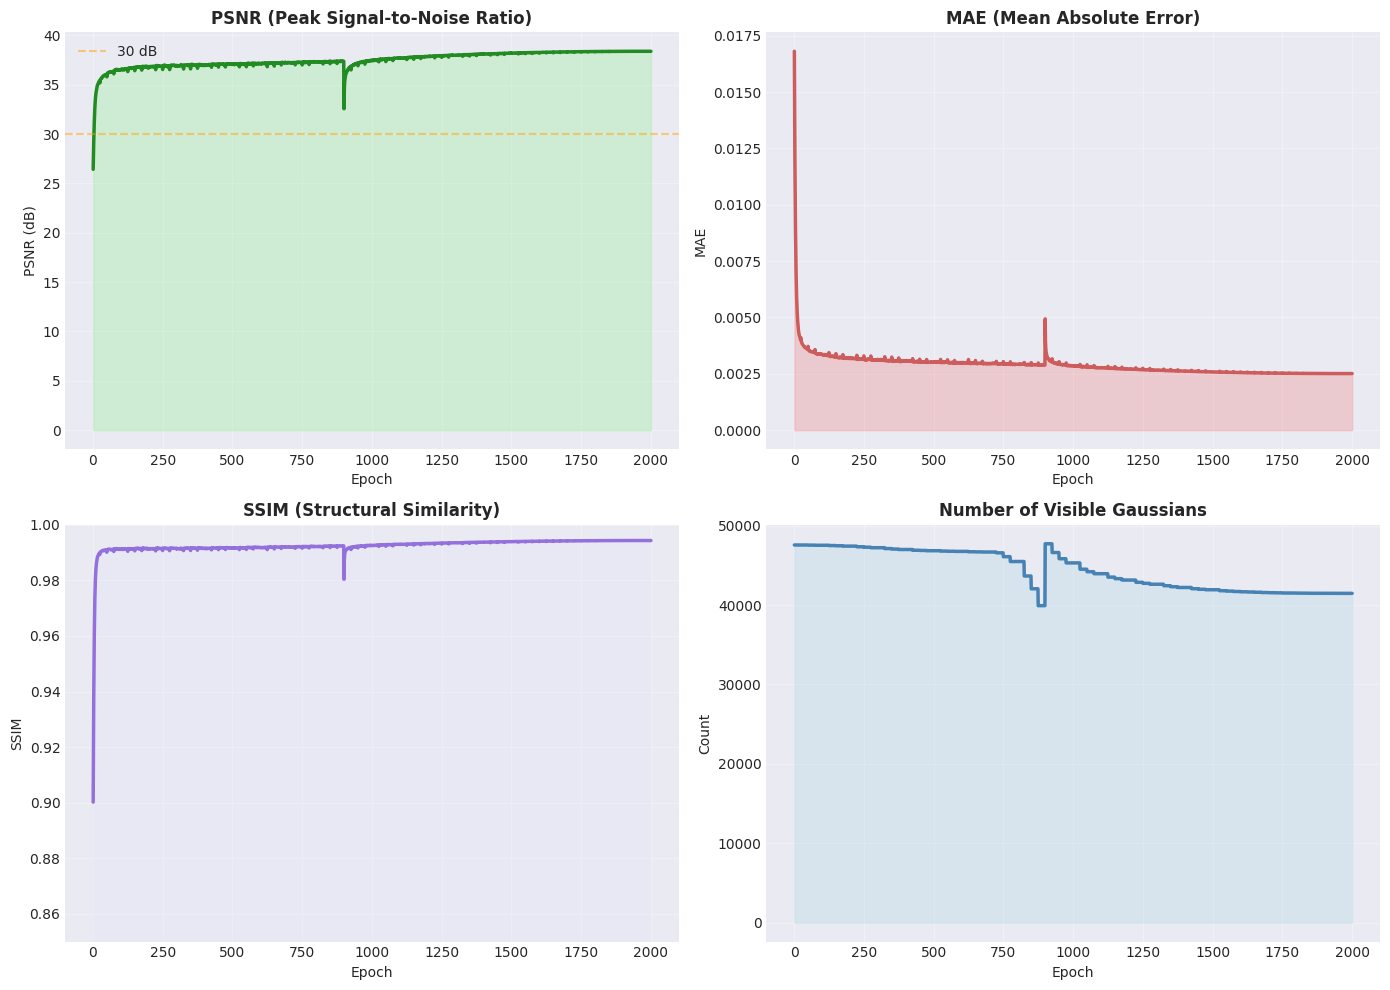


Quality Metrics Summary:
  Initial PSNR: 26.43 dB → Final: 38.39 dB (+11.96 dB)
  Initial SSIM: 0.9002 → Final: 0.9944
  Initial MAE: 0.016808 → Final: 0.002511
  Gaussians: 47564 → 41471


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# PSNR
axes[0, 0].plot(epochs, psnr, linewidth=2.5, color='forestgreen')
axes[0, 0].fill_between(epochs, psnr, alpha=0.3, color='lightgreen')
axes[0, 0].set_title('PSNR (Peak Signal-to-Noise Ratio)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('PSNR (dB)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='30 dB')
axes[0, 0].legend()

# MAE
axes[0, 1].plot(epochs, mae, linewidth=2.5, color='indianred')
axes[0, 1].fill_between(epochs, mae, alpha=0.3, color='lightcoral')
axes[0, 1].set_title('MAE (Mean Absolute Error)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].grid(True, alpha=0.3)

# SSIM (as metric, not loss)
ssim_metric = 1 - ssim_loss
axes[1, 0].plot(epochs, ssim_metric, linewidth=2.5, color='mediumpurple')
axes[1, 0].fill_between(epochs, ssim_metric, alpha=0.3, color='lavender')
axes[1, 0].set_title('SSIM (Structural Similarity)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0.85, 1.0])

# Number of visible Gaussians
axes[1, 1].plot(epochs, n_gaussians, linewidth=2.5, color='steelblue')
axes[1, 1].fill_between(epochs, n_gaussians, alpha=0.3, color='lightblue')
axes[1, 1].set_title('Number of Visible Gaussians', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nQuality Metrics Summary:")
print(f"  Initial PSNR: {psnr[0]:.2f} dB → Final: {psnr[-1]:.2f} dB (+{psnr[-1]-psnr[0]:.2f} dB)")
print(f"  Initial SSIM: {ssim_metric[0]:.4f} → Final: {ssim_metric[-1]:.4f}")
print(f"  Initial MAE: {mae[0]:.6f} → Final: {mae[-1]:.6f}")
print(f"  Gaussians: {int(n_gaussians[0])} → {int(n_gaussians[-1])}")

## 7. Key Epoch Checkpoints Comparison


KEY CHECKPOINT COMPARISON
 Epoch  Total Loss     WMSE  SSIM Loss  Edge Loss  IntKL Loss  PSNR (dB)     SSIM
     1    0.026825 0.006509   0.099793   0.001259    0.000210  26.429524 0.900207
   100    0.002825 0.000787   0.008763   0.000603    0.000191  36.549407 0.991237
   500    0.002546 0.000665   0.008412   0.000617    0.000108  37.072569 0.991588
  1000    0.002307 0.000605   0.007399   0.000563    0.000149  37.471663 0.992601
  1500    0.001949 0.000519   0.006061   0.000473    0.000154  38.193516 0.993939
  2000    0.001843 0.000497   0.005648   0.000450    0.000156  38.387495 0.994352


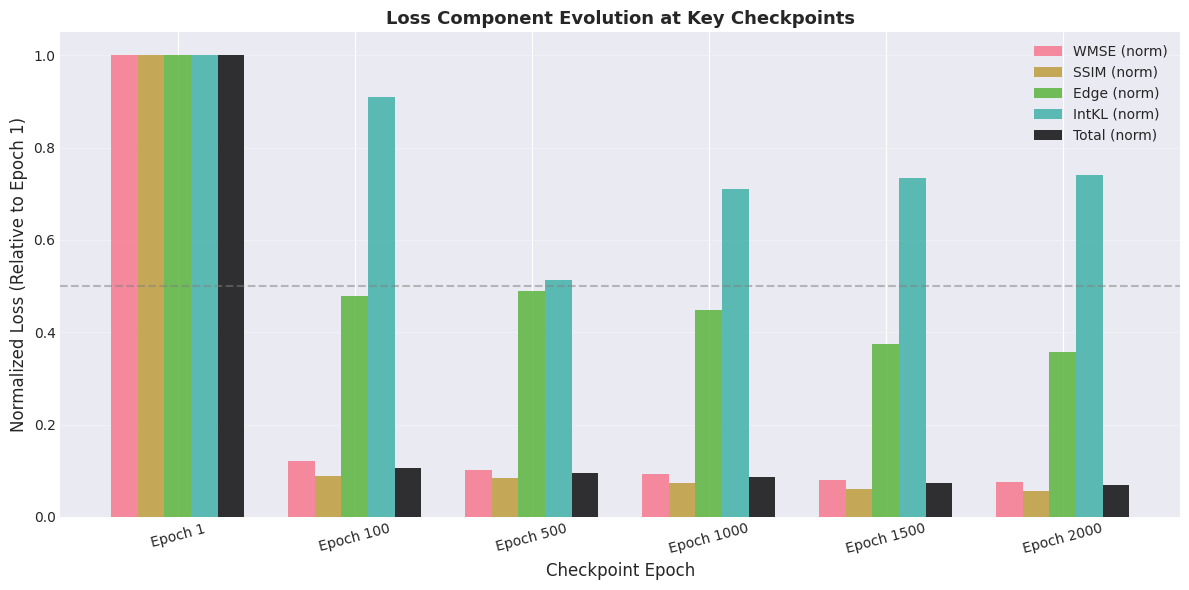

In [12]:
# Select key epochs for comparison
key_epochs = [1, 100, 500, 1000, 1500, 2000]
key_epochs = [e for e in key_epochs if e <= len(history)]

# Extract metrics at key epochs
key_data = {
    'Epoch': key_epochs,
    'Total Loss': [total_loss[e-1] for e in key_epochs],
    'WMSE': [mse_loss[e-1] for e in key_epochs],
    'SSIM Loss': [ssim_loss[e-1] for e in key_epochs],
    'Edge Loss': [edge_loss[e-1] for e in key_epochs],
    'IntKL Loss': [sparsity_loss[e-1] for e in key_epochs],
    'PSNR (dB)': [psnr[e-1] for e in key_epochs],
    'SSIM': [1-ssim_loss[e-1] for e in key_epochs],
}

# Create comparison table
import pandas as pd
df = pd.DataFrame(key_data)
print("\n" + "="*80)
print("KEY CHECKPOINT COMPARISON")
print("="*80)
print(df.to_string(index=False))
print("="*80)

# Visualize key epochs
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(key_epochs))
width = 0.15

# Normalize for visualization
bars1 = ax.bar(x - 2*width, [mse_loss[e-1]/mse_loss[0] for e in key_epochs], 
              width, label='WMSE (norm)', alpha=0.8)
bars2 = ax.bar(x - width, [ssim_loss[e-1]/ssim_loss[0] for e in key_epochs], 
              width, label='SSIM (norm)', alpha=0.8)
bars3 = ax.bar(x, [edge_loss[e-1]/edge_loss[0] for e in key_epochs], 
              width, label='Edge (norm)', alpha=0.8)
if sparsity_loss[0] > 0:
    bars4 = ax.bar(x + width, [sparsity_loss[e-1]/sparsity_loss[0] for e in key_epochs], 
                  width, label='IntKL (norm)', alpha=0.8)
bars5 = ax.bar(x + 2*width, [total_loss[e-1]/total_loss[0] for e in key_epochs], 
              width, label='Total (norm)', alpha=0.8, color='black')

ax.set_xlabel('Checkpoint Epoch', fontsize=12)
ax.set_ylabel('Normalized Loss (Relative to Epoch 1)', fontsize=12)
ax.set_title('Loss Component Evolution at Key Checkpoints', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Epoch {e}' for e in key_epochs], rotation=15)
ax.legend(fontsize=10)
ax.grid(True, axis='y', alpha=0.3)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 8. Summary Statistics

In [13]:
print("\n" + "="*80)
print("TRAINING SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal Training Epochs: {len(history)}")
print(f"\n{'Loss Component':<20} {'Initial':<12} {'Final':<12} {'Best':<12} {'Reduction':<12}")
print("-"*80)

components = [
    ('Total Loss', total_loss),
    ('WMSE', mse_loss),
    ('SSIM Loss', ssim_loss),
    ('Edge Loss', edge_loss),
    ('IntKL Loss', sparsity_loss),
    ('Scale Reg', scale_reg),
]

for name, values in components:
    initial = values[0]
    final = values[-1]
    best = values.min()
    if initial > 0:
        reduction = (1 - final/initial) * 100
    else:
        reduction = 0.0
    print(f"{name:<20} {initial:<12.6f} {final:<12.6f} {best:<12.6f} {reduction:<12.1f}%")

print("\n" + "="*80)
print("QUALITY METRICS")
print("="*80)
print(f"\n{'Metric':<20} {'Initial':<12} {'Final':<12} {'Best':<12} {'Improvement':<12}")
print("-"*80)

print(f"{'PSNR (dB)':<20} {psnr[0]:<12.2f} {psnr[-1]:<12.2f} {psnr.max():<12.2f} {psnr[-1]-psnr[0]:<12.2f}")
ssim_metric = 1 - ssim_loss
print(f"{'SSIM':<20} {ssim_metric[0]:<12.4f} {ssim_metric[-1]:<12.4f} {ssim_metric.max():<12.4f} {ssim_metric[-1]-ssim_metric[0]:<12.4f}")
print(f"{'MAE':<20} {mae[0]:<12.6f} {mae[-1]:<12.6f} {mae.min():<12.6f} {mae[0]-mae[-1]:<12.6f}")

print("\n" + "="*80)


TRAINING SUMMARY STATISTICS

Total Training Epochs: 2000

Loss Component       Initial      Final        Best         Reduction   
--------------------------------------------------------------------------------
Total Loss           0.026825     0.001843     0.001841     93.1        %
WMSE                 0.006509     0.000497     0.000496     92.4        %
SSIM Loss            0.099793     0.005648     0.005641     94.3        %
Edge Loss            0.001259     0.000450     0.000450     64.2        %
IntKL Loss           0.000210     0.000156     0.000100     25.9        %
Scale Reg            0.000022     0.000016     0.000012     25.9        %

QUALITY METRICS

Metric               Initial      Final        Best         Improvement 
--------------------------------------------------------------------------------
PSNR (dB)            26.43        38.39        38.39        11.96       
SSIM                 0.9002       0.9944       0.9944       0.0941      
MAE                  0.01

## 9. Visual Comparison: Rendered Images at Key Epochs

Now let's load checkpoints and render actual images to see how each loss component affects visual quality.

In [14]:
import torch
import sys
sys.path.insert(0, '/workspace/hisnegs/src/renderer')

# Import rendering modules
from rendering import (
    Camera, GaussianParameters,
    apply_aspect_correction, render_mip_projection
)

print("Rendering modules loaded successfully")

Rendering modules loaded successfully


In [15]:
# Load volume for ground truth rendering
import tifffile

vol_path = '/workspace/hisnegs/dataset/10-2900-control-cell-05_cropped_corrected.tif'
print(f"Loading volume from: {vol_path}")

vol = tifffile.imread(vol_path).astype(np.float32)
Z, Y, X = vol.shape
vol = vol / vol.max()  # Normalize to [0, 1]

print(f"Volume shape: {vol.shape}")
print(f"Volume range: [{vol.min():.3f}, {vol.max():.3f}]")

# Compute aspect scales
aspect_scales = np.array([X, Y, Z], dtype=np.float32)
aspect_scales = aspect_scales / aspect_scales.max()
print(f"Aspect scales: {aspect_scales}")

# Convert to torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vol_torch = torch.from_numpy(vol).to(device)
aspect_torch = torch.from_numpy(aspect_scales).to(device)
print(f"Using device: {device}")

Loading volume from: /workspace/hisnegs/dataset/10-2900-control-cell-05_cropped_corrected.tif
Volume shape: (100, 647, 813)
Volume range: [0.008, 1.000]
Aspect scales: [1.         0.795818   0.12300123]


Using device: cuda


In [16]:
# Set up camera using the from_fov class method
camera = Camera.from_fov(
    fov_x_deg=50.0,
    width=X,
    height=Y,
    near=0.1,
    far=10.0
)

print(f"Camera: {X}×{Y}, fx={camera.fx:.1f}, fy={camera.fy:.1f}")

# Generate a test viewpoint (oblique view)
theta = np.radians(30)  # elevation
phi = np.radians(45)    # azimuth
radius = 2.5

cam_pos = np.array([
    radius * np.sin(theta) * np.cos(phi),
    radius * np.sin(theta) * np.sin(phi),
    radius * np.cos(theta)
], dtype=np.float32)

# Look-at matrix
forward = -cam_pos / np.linalg.norm(cam_pos)
right = np.cross(np.array([0, 0, 1], dtype=np.float32), forward)
right = right / np.linalg.norm(right)
up = np.cross(forward, right)

R = np.stack([right, up, -forward], axis=0).T  # World-to-camera rotation
T = -R @ cam_pos  # World-to-camera translation

R_torch = torch.from_numpy(R).to(device)
T_torch = torch.from_numpy(T).to(device)

print(f"Test viewpoint: elevation={np.degrees(theta):.1f}°, azimuth={np.degrees(phi):.1f}°")
print(f"Camera position: {cam_pos}")

Camera: 813×647, fx=871.7, fy=871.7
Test viewpoint: elevation=30.0°, azimuth=45.0°
Camera position: [0.8838835 0.8838835 2.1650636]


### 9.1 Render Ground Truth MIP

Rendering ground truth MIP...


Ground truth MIP shape: torch.Size([647, 813])
Ground truth MIP range: [0.000, 0.125]


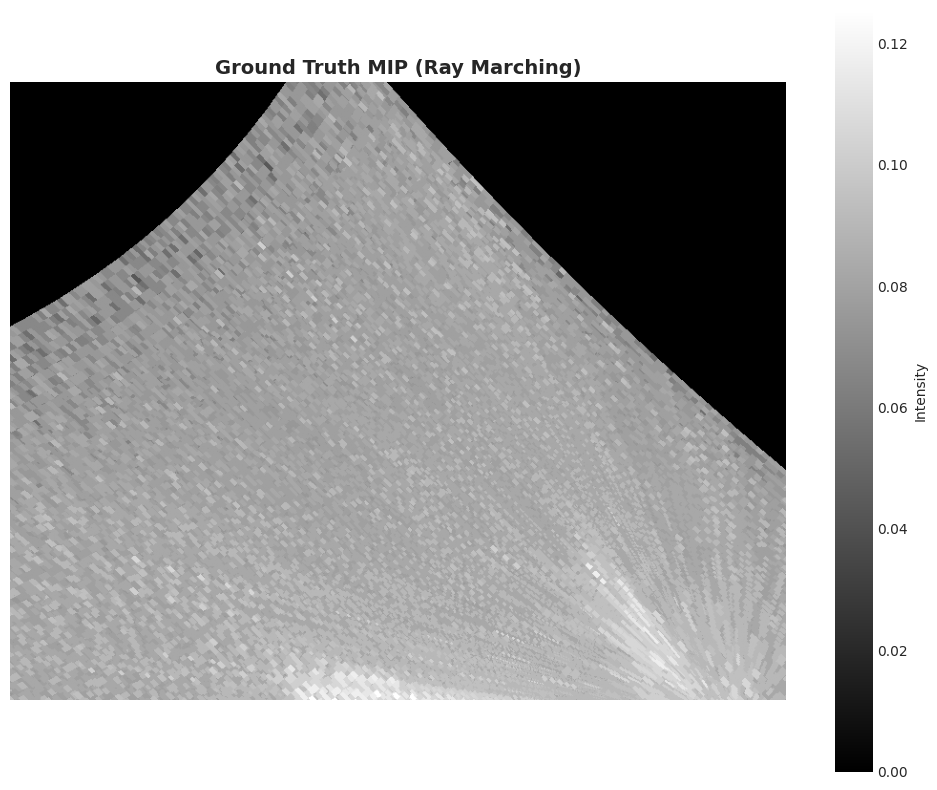

In [17]:
# Render ground truth via ray marching
def render_gt_mip(volume, camera, R, T, aspect_scales, n_samples=200):
    """Render ground truth MIP via ray marching."""
    H, W = camera.height, camera.width
    device = volume.device
    
    # Generate rays
    u = torch.arange(W, device=device, dtype=torch.float32) + 0.5
    v = torch.arange(H, device=device, dtype=torch.float32) + 0.5
    uu, vv = torch.meshgrid(u, v, indexing='xy')
    
    # Ray directions in camera space
    dirs_cam = torch.stack([
        (uu - camera.cx) / camera.fx,
        (vv - camera.cy) / camera.fy,
        torch.ones_like(uu)
    ], dim=-1)  # (H, W, 3)
    
    # Transform to world space
    R_inv = R.T
    dirs_world = torch.einsum('ij,hwj->hwi', R_inv, dirs_cam)
    dirs_world = dirs_world / torch.norm(dirs_world, dim=-1, keepdim=True)
    
    ray_origin = -torch.einsum('ij,j->i', R_inv, T)
    
    # Ray marching
    t_vals = torch.linspace(0.5, 6.0, n_samples, device=device)
    mip = torch.zeros(H, W, device=device)
    
    Z, Y, X = volume.shape
    
    for i, t in enumerate(t_vals):
        # Sample positions
        pos = ray_origin[None, None, :] + t * dirs_world  # (H, W, 3)
        
        # Apply aspect correction
        pos_corrected = pos * aspect_scales
        
        # Convert to voxel coordinates
        vox_coords = torch.stack([
            (pos_corrected[..., 0] + 1) * 0.5 * (X - 1),
            (pos_corrected[..., 1] + 1) * 0.5 * (Y - 1),
            (pos_corrected[..., 2] + 1) * 0.5 * (Z - 1),
        ], dim=-1)
        
        # Sample volume (trilinear interpolation)
        # Clamp to valid range
        valid = (
            (vox_coords[..., 0] >= 0) & (vox_coords[..., 0] < X) &
            (vox_coords[..., 1] >= 0) & (vox_coords[..., 1] < Y) &
            (vox_coords[..., 2] >= 0) & (vox_coords[..., 2] < Z)
        )
        
        # Simple nearest-neighbor sampling for speed
        ix = vox_coords[..., 0].long().clamp(0, X-1)
        iy = vox_coords[..., 1].long().clamp(0, Y-1)
        iz = vox_coords[..., 2].long().clamp(0, Z-1)
        
        samples = volume[iz, iy, ix]
        samples = samples * valid.float()
        
        # Update MIP
        mip = torch.maximum(mip, samples)
    
    return mip

print("Rendering ground truth MIP...")
gt_mip = render_gt_mip(vol_torch, camera, R_torch, T_torch, aspect_torch, n_samples=200)
print(f"Ground truth MIP shape: {gt_mip.shape}")
print(f"Ground truth MIP range: [{gt_mip.min():.3f}, {gt_mip.max():.3f}]")

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(gt_mip.cpu().numpy(), cmap='gray')
plt.title('Ground Truth MIP (Ray Marching)', fontsize=14, fontweight='bold')
plt.colorbar(label='Intensity')
plt.axis('off')
plt.tight_layout()
plt.show()

### 9.2 Load and Render Checkpoints at Key Epochs

In [18]:
def load_checkpoint_and_render(ckpt_path, camera, R, T, aspect_scales, beta=50.0):
    """Load a checkpoint and render a MIP using the existing rendering pipeline."""
    # Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device)
    
    means = ckpt['means'].to(device)
    log_scales = ckpt['log_scales'].to(device)
    quaternions = ckpt['quaternions'].to(device)
    log_intensities = ckpt.get('log_intensities', ckpt.get('log_amplitudes')).to(device)
    
    K = means.shape[0]
    
    # Build covariances from log_scales and quaternions
    scales = torch.exp(log_scales).clamp(1e-5, 1e2)
    q = torch.nn.functional.normalize(quaternions, p=2, dim=-1)
    w, x, y, z = q[:, 0], q[:, 1], q[:, 2], q[:, 3]
    
    # Rotation matrix from quaternion
    Rm = torch.zeros(K, 3, 3, device=device, dtype=q.dtype)
    Rm[:, 0, 0] = 1 - 2*(y*y + z*z)
    Rm[:, 0, 1] = 2*(x*y - w*z)
    Rm[:, 0, 2] = 2*(x*z + w*y)
    Rm[:, 1, 0] = 2*(x*y + w*z)
    Rm[:, 1, 1] = 1 - 2*(x*x + z*z)
    Rm[:, 1, 2] = 2*(y*z - w*x)
    Rm[:, 2, 0] = 2*(x*z - w*y)
    Rm[:, 2, 1] = 2*(y*z + w*x)
    Rm[:, 2, 2] = 1 - 2*(x*x + y*y)
    
    # Covariance = R * S^2 * R^T
    S2 = torch.diag_embed(scales ** 2)
    covariances = Rm @ S2 @ Rm.transpose(-2, -1)
    intensities = torch.sigmoid(log_intensities)
    
    # Apply aspect correction to means and covariances
    S_aspect = torch.diag(aspect_scales)
    means_corrected = means * aspect_scales[None, :]
    covariances_corrected = S_aspect[None, :, :] @ covariances @ S_aspect[None, :, :].transpose(-2, -1)
    
    # Create GaussianParameters object
    gaussians = GaussianParameters()
    gaussians.means = means_corrected
    gaussians.covariances = covariances_corrected
    gaussians.intensities = intensities
    
    # Render using the existing pipeline
    image, n_visible = render_mip_projection(
        gaussians=gaussians,
        camera=camera,
        R=R,
        T=T,
        beta=beta,
        chunk_size=4096
    )
    
    return image, n_visible

# Select key epochs to visualize
render_epochs = [100, 500, 1000, 1500, 2000]
ckpt_dir = Path('/workspace/hisnegs/src/renderer/checkpoints/train_swme_ssim_edge_inte_checkpoint')

print("Loading and rendering checkpoints...")
rendered_images = {}
for ep in render_epochs:
    ckpt_path = ckpt_dir / f'splat_swme_ssim_edge_inte_ep{ep}.pt'
    if ckpt_path.exists():
        print(f"  Epoch {ep}...", end='', flush=True)
        img, n_vis = load_checkpoint_and_render(ckpt_path, camera, R_torch, T_torch, aspect_torch, beta=50.0)
        rendered_images[ep] = img.cpu().numpy()
        print(f" done ({n_vis} visible Gaussians)")
    else:
        print(f"  Epoch {ep}: checkpoint not found")

print(f"\nRendered {len(rendered_images)} checkpoints")

Loading and rendering checkpoints...
  Epoch 100...

TypeError: GaussianParameters.__init__() missing 3 required positional arguments: 'means', 'covariances', and 'intensities'

### 9.3 Visual Comparison Grid

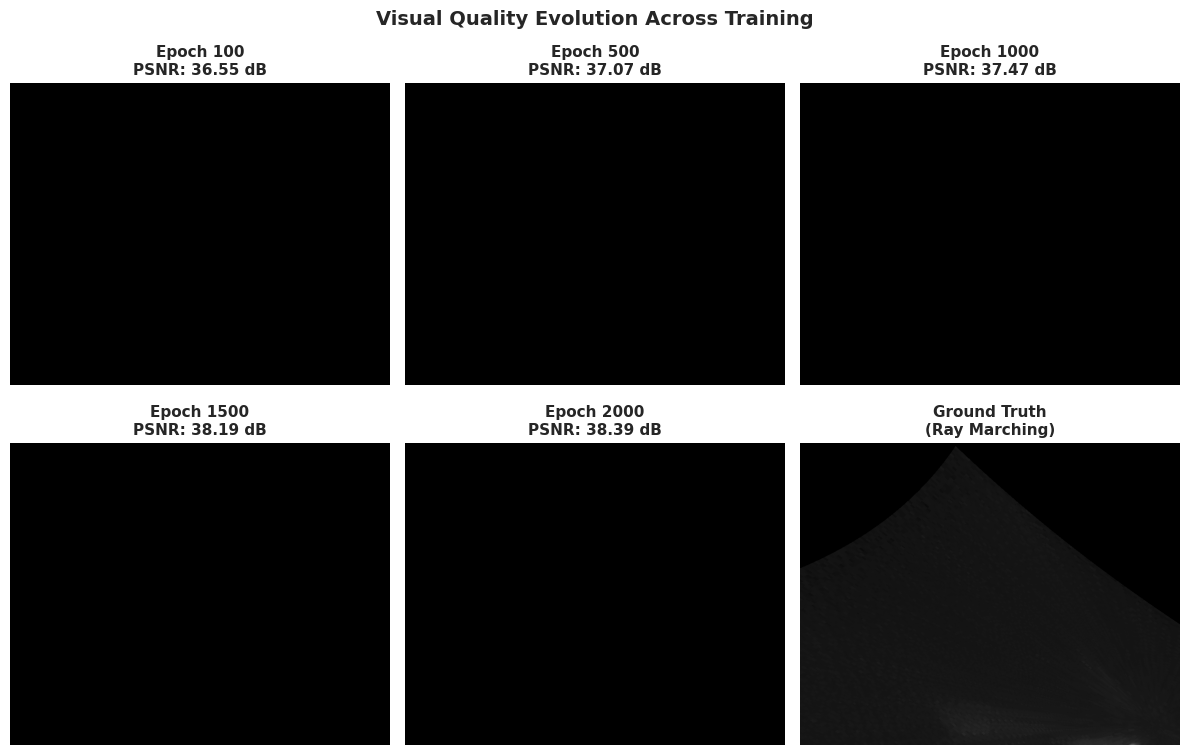

In [ ]:
# Create comparison grid
n_epochs = len(rendered_images)
fig, axes = plt.subplots(2, (n_epochs + 2) // 2, figsize=(4 * ((n_epochs + 2) // 2), 8))
axes = axes.flatten()

gt_np = gt_mip.cpu().numpy()

# Display rendered images
for idx, (ep, img) in enumerate(sorted(rendered_images.items())):
    axes[idx].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[idx].set_title(f'Epoch {ep}\nPSNR: {psnr[ep-1]:.2f} dB', fontsize=11, fontweight='bold')
    axes[idx].axis('off')

# Add ground truth
axes[-1].imshow(gt_np, cmap='gray', vmin=0, vmax=1)
axes[-1].set_title('Ground Truth\n(Ray Marching)', fontsize=11, fontweight='bold')
axes[-1].axis('off')

# Hide any extra subplots
for idx in range(len(rendered_images) + 1, len(axes)):
    axes[idx].axis('off')

fig.suptitle('Visual Quality Evolution Across Training', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.4 Difference Maps (Error Visualization)

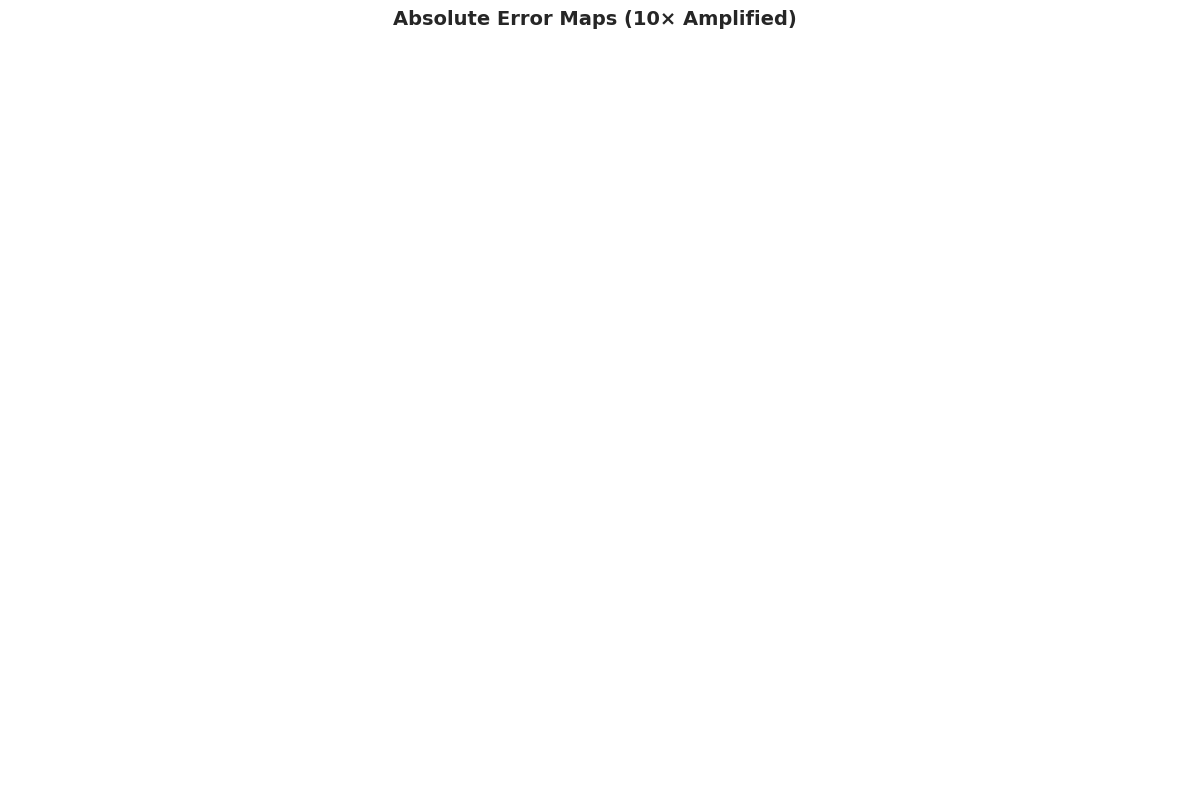

In [ ]:
# Create difference map grid
fig, axes = plt.subplots(2, (n_epochs + 1) // 2, figsize=(4 * ((n_epochs + 1) // 2), 8))
axes = axes.flatten()

gt_np = gt_mip.cpu().numpy()

for idx, (ep, img) in enumerate(sorted(rendered_images.items())):
    diff = np.abs(img - gt_np)
    im = axes[idx].imshow(diff * 10, cmap='hot', vmin=0, vmax=1)  # 10x amplification
    axes[idx].set_title(f'Epoch {ep} Error (10×)\nMAE: {mae[ep-1]:.4f}', fontsize=11, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

# Hide any extra subplots
for idx in range(len(rendered_images), len(axes)):
    axes[idx].axis('off')

fig.suptitle('Absolute Error Maps (10× Amplified)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.5 Detail Comparison: Zoom into Fine Structures

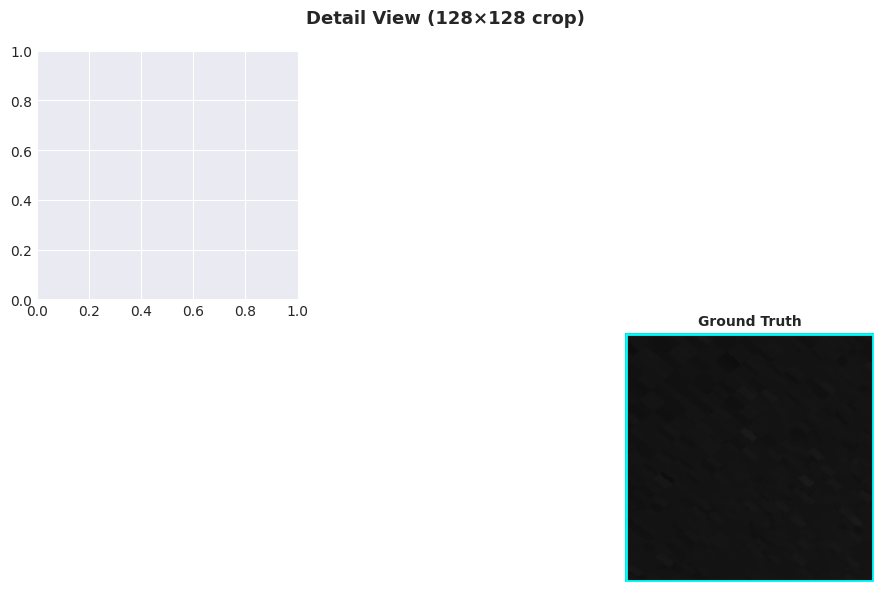

In [ ]:
# Select a region with fine neurite structures
crop_y, crop_x = 150, 200
crop_size = 128

fig, axes = plt.subplots(2, (n_epochs + 2) // 2, figsize=(3 * ((n_epochs + 2) // 2), 6))
axes = axes.flatten()

gt_crop = gt_np[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]

for idx, (ep, img) in enumerate(sorted(rendered_images.items())):
    crop = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
    axes[idx].imshow(crop, cmap='gray', vmin=0, vmax=1)
    axes[idx].set_title(f'Epoch {ep}', fontsize=10, fontweight='bold')
    axes[idx].axis('off')
    # Add red box to show this is a crop
    axes[idx].add_patch(plt.Rectangle((0, 0), crop_size-1, crop_size-1, 
                                      fill=False, edgecolor='cyan', linewidth=2))

# Add ground truth crop
axes[-1].imshow(gt_crop, cmap='gray', vmin=0, vmax=1)
axes[-1].set_title('Ground Truth', fontsize=10, fontweight='bold')
axes[-1].axis('off')
axes[-1].add_patch(plt.Rectangle((0, 0), crop_size-1, crop_size-1, 
                                 fill=False, edgecolor='cyan', linewidth=2))

# Hide extra subplots
for idx in range(len(rendered_images) + 1, len(axes)):
    axes[idx].axis('off')

fig.suptitle(f'Detail View ({crop_size}×{crop_size} crop)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.6 Side-by-Side Comparison: First vs Final

In [ ]:
# Compare early, middle, and final epochs
if 100 in rendered_images and 1000 in rendered_images and 2000 in rendered_images:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: Full images
    axes[0, 0].imshow(rendered_images[100], cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title(f'Epoch 100\nPSNR: {psnr[99]:.2f} dB', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(rendered_images[1000], cmap='gray', vmin=0, vmax=1)
    axes[0, 1].set_title(f'Epoch 1000\nPSNR: {psnr[999]:.2f} dB', fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(rendered_images[2000], cmap='gray', vmin=0, vmax=1)
    axes[0, 2].set_title(f'Epoch 2000\nPSNR: {psnr[1999]:.2f} dB', fontsize=11, fontweight='bold')
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(gt_np, cmap='gray', vmin=0, vmax=1)
    axes[0, 3].set_title('Ground Truth', fontsize=11, fontweight='bold')
    axes[0, 3].axis('off')
    
    # Row 2: Difference maps
    diff_100 = np.abs(rendered_images[100] - gt_np)
    diff_1000 = np.abs(rendered_images[1000] - gt_np)
    diff_2000 = np.abs(rendered_images[2000] - gt_np)
    
    im0 = axes[1, 0].imshow(diff_100 * 10, cmap='hot', vmin=0, vmax=1)
    axes[1, 0].set_title(f'Error (10×)\nMAE: {mae[99]:.4f}', fontsize=10)
    axes[1, 0].axis('off')
    plt.colorbar(im0, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    im1 = axes[1, 1].imshow(diff_1000 * 10, cmap='hot', vmin=0, vmax=1)
    axes[1, 1].set_title(f'Error (10×)\nMAE: {mae[999]:.4f}', fontsize=10)
    axes[1, 1].axis('off')
    plt.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    im2 = axes[1, 2].imshow(diff_2000 * 10, cmap='hot', vmin=0, vmax=1)
    axes[1, 2].set_title(f'Error (10×)\nMAE: {mae[1999]:.4f}', fontsize=10)
    axes[1, 2].axis('off')
    plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
    
    axes[1, 3].axis('off')
    # Add text summary
    summary_text = (
        f"Quality Improvement:\\n"
        f"\\nPSNR: {psnr[99]:.2f} → {psnr[1999]:.2f} dB"
        f"\\n(+{psnr[1999]-psnr[99]:.2f} dB)"
        f"\\n\\nMAE: {mae[99]:.4f} → {mae[1999]:.4f}"
        f"\\n(-{mae[99]-mae[1999]:.4f})"
        f"\\n\\nSSIM: {1-ssim_loss[99]:.4f} → {1-ssim_loss[1999]:.4f}"
    )
    axes[1, 3].text(0.1, 0.5, summary_text, fontsize=11, 
                    verticalalignment='center', family='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    fig.suptitle('Training Progression: Early → Mid → Final', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()